###Load processed dataset and normalization

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, accuracy_score
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neural_network import MLPClassifier

# Comment this line if you use light color scheme
plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = (16, 9)

In [3]:
data_ready = pd.read_csv('drive/MyDrive/csgo_data_processed_unnorm.csv')

In [4]:
data_ready.shape

(122410, 58)

In [5]:
data_ready = data_ready.drop(data_ready.columns[0], axis=1)
data_ready.head()

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,round_winner,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_famas,t_weapon_galilar,t_weapon_glock,ct_weapon_m4a1s,ct_weapon_m4a4,t_weapon_mac10,ct_weapon_mp9,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_molotovgrenade
0,0,1,0,0,0,0,0,0,175.00,0.0,0.0,0,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1,0,0,0,0,0,0,156.03,0.0,0.0,0,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
2,0,1,0,0,0,0,0,0,96.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0,1,0,0,0,0,0,0,76.03,0.0,0.0,0,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1,0,0,0,0,0,0,174.97,1.0,0.0,0,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,CT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data = data_ready#.sample(10000)
data.shape

(122410, 57)

In [7]:
Y = data['round_winner']
data = data.drop(['round_winner'], axis=1)

In [8]:
data_stand = (data - data.mean(axis = 0))/data.std(axis = 0)
data_stand.describe()

,de_cache,de_dust2,de_inferno,de_mirage,de_nuke,de_overpass,de_train,de_vertigo,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_famas,t_weapon_galilar,t_weapon_glock,ct_weapon_m4a1s,ct_weapon_m4a4,t_weapon_mac10,ct_weapon_mp9,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_molotovgrenade
count,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05,1.224100e+05
mean,1.732851e-14,1.307772e-14,-2.236603e-14,-3.029724e-15,1.481080e-13,-2.294063e-14,-1.794098e-14,-1.362303e-15,-3.982956e-13,2.963790e-15,1.196875e-16,8.486572e-16,-1.097754e-15,-7.064677e-16,1.334322e-15,1.457048e-15,-1.181652e-15,-6.050321e-16,-3.990456e-15,6.669069e-15,2.471431e-15,-4.284551e-16,-1.244370e-14,-2.018571e-14,1.421405e-14,-1.927248e-14,-1.474041e-14,1.053678e-14,2.331931e-14,5.770488e-14,-8.834825e-15,3.832387e-16,-7.556439e-15,4.078579e-14,-9.069489e-16,2.888523e-14,-6.099633e-16,-8.974913e-14,-2.942655e-14,1.020922e-14,-1.009923e-15,6.639734e-16,-2.270325e-16,-1.603622e-15,-6.888222e-15,5.320283e-15,7.176840e-15,-2.292477e-15,-6.540272e-15,2.054035e-15,-2.120041e-15,-1.099923e-15,5.252760e-15,-5.240086e-15,2.136497e-15,2.924266e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.443746e-02,-4.699476e-01,-4.914177e-01,-4.229651e-01,-4.289748e-01,-3.605310e-01,-3.519399e-01,-3.163643e-01,-1.797053e+00,-1.400570e+00,-1.405696e+00,-3.547628e-01,-3.115098e+00,-2.878197e+00,-1.836769e+00,-1.709535e+00,-8.728477e-01,-9.242140e-01,-1.115359e+00,-1.379292e+00,-1.004947e+00,-3.545210e+00,-3.473175e+00,-4.701341e-01,-9.120451e-01,-2.924449e-01,-8.521283e-01,-6.738269e-01,-3.408521e-01,-2.790931e-01,-2.831460e-01,-2.717236e-01,-2.036060e+00,-2.427621e-01,-8.828025e-01,-2.606018e-01,-3.112070e-01,-4.316165e-01,-7.239215e-01,-2.247249e-01,-5.280604e-01,-4.674772e-01,-2.140449e-01,-2.003915e+00,-2.788613e-01,-4.439486e-01,-5.034342e-01,-4.093834e-01,-7.015631e-01,-5.422971e-01,-1.045333e+00,-1.035457e+00,-8.866441e-01,-8.895655e-01,-6.871819e-01,-8.129257e-01
25%,-3.443746e-02,-4.699476e-01,-4.914177e-01,-4.229651e-01,-4.289748e-01,-3.605310e-01,-3.519399e-01,-3.163643e-01,-7.888871e-01,-7.743129e-01,-7.837464e-01,-3.547628e

In [9]:
data = data_stand

###Постановка задачи

Собраны данные из множества онлайн-матчей CS:GO, игры, где сражаются две команды по пять человек: террористы, цель которых установить и подорвать бомбу по истечению 45 секунд, либо уничтожить весь спецназ; спецназ, цель которого уничтожить террористов либо обезвредить установленную бомбу.  
Каждый раунд, с некоторым интервалом времени делался "снимок" игры, а именно - количество здоровья команды, количество брони, наличие оружия, факт устрановки бомбы и текущий счет.

Задача состоит в определении победителя раунда по данным показателям.

###MLP

Разбиваем на обучающую и тестувую выборки

In [10]:
X = data
y = (Y == 'CT').astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(85687, 36723)

#### One hidden layer

Попробуем найти оптимальынй размер для 1/1 скрытого слоя

In [12]:
layer_sizes = [ int(np.round(x)) for x in np.logspace(0.5, 4, 8, endpoint=False) ]
layer_sizes

[3, 9, 24, 65, 178, 487, 1334, 3652]

In [ ]:
%%time
one_layer_train_acc = []
one_layer_test_acc  = []
for layer_size in layer_sizes:
    mlp_model = MLPClassifier(hidden_layer_sizes = (layer_size,), max_iter = 256, random_state = 42)
    mlp_model.fit(X_train, y_train)
    one_layer_train_acc.append(mlp_model.score(X_train, y_train))
    one_layer_test_acc.append(mlp_model.score(X_test, y_test))
    print("Train: {:.5f}, Test: {:.5f}".format(one_layer_train_acc[-1], one_layer_test_acc[-1]))

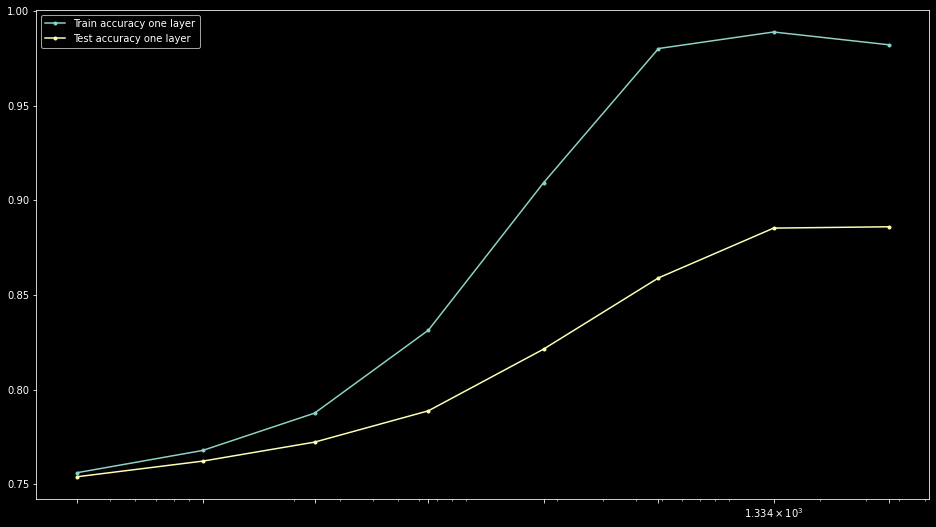

In [ ]:
plt.plot(layer_sizes, one_layer_train_acc, marker='.', ls = '-', label='Train accuracy one layer')
plt.plot(layer_sizes, one_layer_test_acc,  marker='.', ls = '-', label='Test accuracy one layer')
plt.xscale("log")
plt.xticks(layer_sizes)
plt.legend()

С каждой итерацией точность на тестовой выборке продолжает улучшаться, причем при размере слоя 487, точность обучающей выборки выросла до 98%, и казалось бы, модель переобучена, но тем не менее показывает все лучшие результаты на тестовой выборке.

In [ ]:
one_layer_max = max(one_layer_test_acc)
first_layer_size = layer_sizes[one_layer_test_acc.index(one_layer_max)]
first_layer_size, one_layer_max

(3652, 0.8860659532173297)

Лучший результат дает нам точность в 88%, что превышает на 7% результаты полученные стандартными алгоритмами.

#### Two hidden layers

Поскольку такое большое число нейронов на первом скрытом слое в комбинации со вторым приведет к невыносимо долгому обучению, доверимся интуиции и возьмем 128 нейронов для первого слоя, что чуть больше чем 2*input_layer_size.

In [ ]:
two_layer_train_acc = []
two_layer_test_acc  = []

for layer_size in layer_sizes:
    mlp_model = MLPClassifier(hidden_layer_sizes = (128, layer_size), max_iter = 256, random_state = 42)
    mlp_model.fit(X_train, y_train)
    two_layer_train_acc.append(mlp_model.score(X_train, y_train))
    two_layer_test_acc.append(mlp_model.score(X_test, y_test))
    print("Train: {:.5f}, Test: {:.5f}".format(
        two_layer_train_acc[-1],
        two_layer_test_acc[-1])
    )

In [ ]:
#cache
two_layer_train_acc = [0.87708,0.89787,0.92523,0.96842,0.98216,0.99075,0.99328,0.98762,]
two_layer_test_acc = [0.80535,0.81407,0.82482,0.84214,0.86044,0.87722,0.88754,0.88884]

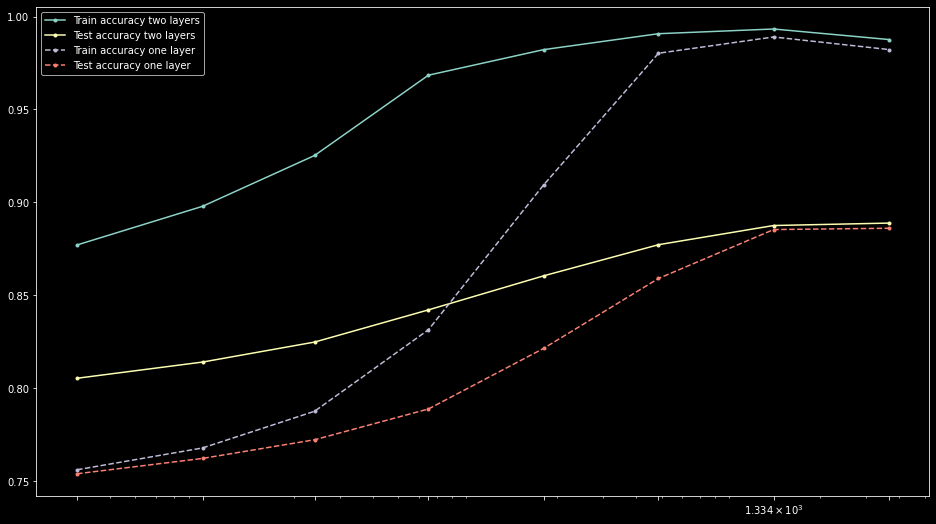

In [ ]:
plt.plot(layer_sizes, two_layer_train_acc, marker='.', ls = '-',  label='Train accuracy two layers')
plt.plot(layer_sizes, two_layer_test_acc,  marker='.', ls = '-',  label='Test accuracy two layers' )
plt.plot(layer_sizes, one_layer_train_acc, marker='.', ls = '--', label='Train accuracy one layer')
plt.plot(layer_sizes, one_layer_test_acc,  marker='.', ls = '--', label='Test accuracy one layer')
plt.xscale("log")
plt.xticks(layer_sizes)
plt.legend()

In [ ]:
two_layer_max = max(two_layer_test_acc)
second_layer_size = layer_sizes[two_layer_test_acc.index(two_layer_max)]
second_layer_size, two_layer_max, one_layer_test_acc[2]

(3652, 0.8888435040710182, 0.7722680608882716)

И снова таже картина, точность на тестовой выборке растет с увеличением количества нейронов на втором скрытом слое. 

#### Regularization

Снова доверимся интуиции и возьмем для второго слоя число, после которого рост точности сильно замедлился, чтобы подобрать оптимальный параметр регуляризации.

In [ ]:
%%time
mlp_model = MLPClassifier(hidden_layer_sizes = (128, 1024), max_iter = 2048, random_state = 42)
mlp_model.fit(X_train, y_train)
print("Train: {:.5f}, Test: {:.5f}".format(
    mlp_model.score(X_train, y_train),
    mlp_model.score(X_test, y_test))
)

Train: 0.99380, Test: 0.89148
CPU times: user 12min 33s, sys: 4min 16s, total: 16min 50s
Wall time: 8min 33s


Тут даже повезло получить рекордную точность на тестовой выборке, 

In [17]:
alphas = [ np.round(0.1** x, 10) for x in range(0, 8) ]
alphas.sort()
alphas

[1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0]

In [16]:
%%time
diff_alpha_train_acc = []
diff_alpha_test_acc  = []
for alpha_value in alphas:
    mlp_model = MLPClassifier(alpha = alpha_value, hidden_layer_sizes = (128, 1024), max_iter = 256, random_state = 42)
    mlp_model.fit(X_train, y_train)
    diff_alpha_train_acc.append(mlp_model.score(X_train, y_train))
    diff_alpha_test_acc.append(mlp_model.score(X_test, y_test))
    print("Train: {:.5f}, Test: {:.5f}".format(
        diff_alpha_train_acc[-1],
        diff_alpha_test_acc[-1])
    )

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Train: 0.93763, Test: 0.85110
Train: 0.76855, Test: 0.76315
CPU times: user 1h 39min 13s, sys: 25min 1s, total: 2h 4min 14s
Wall time: 1h 3min 10s


In [18]:
#load cached
diff_alpha_train_acc = [0.99362,0.99111,0.99148,0.99380,0.99120,0.98665,0.93763, 0.76855]
diff_alpha_test_acc = [0.88740,0.88400,0.88495,0.89148,0.88525,0.88133,0.85110, 0.76315]

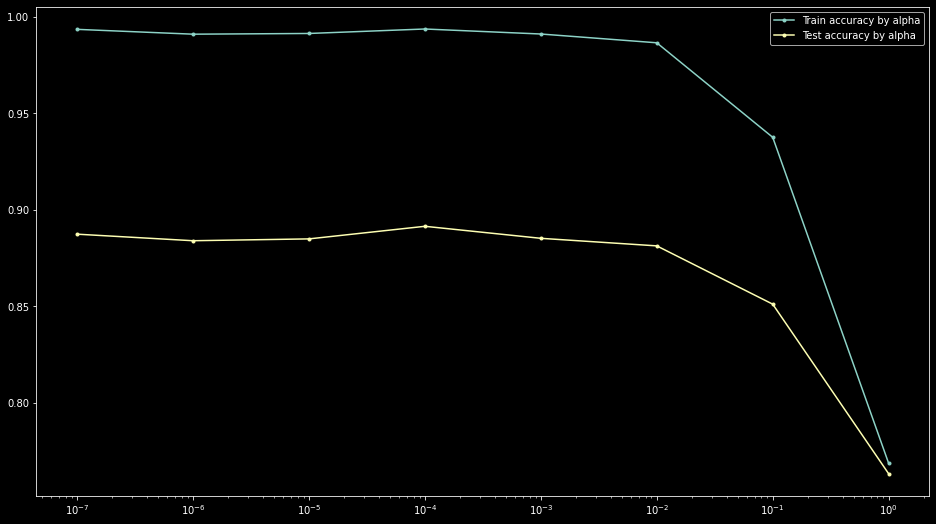

In [19]:
plt.plot(alphas, diff_alpha_train_acc, marker='.', ls = '-', label='Train accuracy by alpha')
plt.plot(alphas, diff_alpha_test_acc,  marker='.', ls = '-', label='Test accuracy by alpha')
plt.xscale("log")
plt.xticks(alphas)
plt.legend()

In [20]:
alpha_max = max(diff_alpha_test_acc)
best_alpha = alphas[diff_alpha_test_acc.index(alpha_max)]
best_alpha, alpha_max

(0.0001, 0.89148)

С увеличением параметра регуляризации точность падает, а оптимальным значением оказалось стандартное

In [ ]:
%%time
mlp_model = MLPClassifier(alpha = best_alpha, hidden_layer_sizes = (128, 1024), max_iter = 2048, random_state = 42)
mlp_model.fit(X_train, y_train)
print("Train: {:.5f}, Test: {:.5f}".format(
    mlp_model.score(X_train, y_train),
    mlp_model.score(X_test, y_test))
)

Train: 0.99380, Test: 0.89148
CPU times: user 17min 18s, sys: 6min 12s, total: 23min 31s
Wall time: 12min 2s


In [ ]:
from sklearn.metrics import classification_report
y_test_pred  = mlp_model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     18669
           1       0.88      0.86      0.87     18054

    accuracy                           0.87     36723
   macro avg       0.87      0.87      0.87     36723
weighted avg       0.87      0.87      0.87     36723



### Conclusions

К сожалению, большой объем данных и признаков не позволяет увеличивать число нейронов, для меня задача свелась к нахождению оптимального их числа, чтобы получить достаточно точную и не сильно большую модель.

Тем не менее, по сравнению с классическими методами класификации, результат получился значительно лучше. Почти уверен, что имея достаточно времени и мощностей можно добить и до 90%.

Так же стоит запусть кросс валидацию для текущей эвристики, чтобы убедиться, что это не везение, или подобрать параметры по лучше.

### Cross validation

#### Small sizes CV

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=256, random_state = 42)

In [ ]:
input_size = data.shape[1]
print(input_size)
layer_sizes = [ 2**i for i in range(1, 8) ]
layers_sizes = []
for l1 in layer_sizes[:4]:
    for l2 in layer_sizes[4:]:
        if l1 <= l2:
            layers_sizes.append((l1, l2))
print(len(layers_sizes))
print(layers_sizes)

56
12
[(2, 32), (2, 64), (2, 128), (4, 32), (4, 64), (4, 128), (8, 32), (8, 64), (8, 128), (16, 32), (16, 64), (16, 128)]


In [ ]:
alphas = alphas = np.logspace(-5, 3, 5)
alphas.sort()
alphas

array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03])

In [ ]:
parameter_space = {
    'hidden_layer_sizes': layers_sizes,
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': alphas,
    'learning_rate': ['constant','adaptive'],
}
parameter_space

{'activation': ['relu'],
 'alpha': array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03]),
 'hidden_layer_sizes': [(2, 32),
  (2, 64),
  (2, 128),
  (4, 32),
  (4, 64),
  (4, 128),
  (8, 32),
  (8, 64),
  (8, 128),
  (16, 32),
  (16, 64),
  (16, 128)],
 'learning_rate': ['constant', 'adaptive'],
 'solver': ['adam']}

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=256, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state...
             iid='deprecated', n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'alpha': array([1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03]),
                         'hidden_layer_sizes': [(2, 32), (2, 64), (2, 128),
                                

In [ ]:
print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
df_array = []
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    row = {}
    row['accuracy'] = mean
    row['learning_rate'] = params['learning_rate']
    row['alpha'] = params['alpha']
    row['alpha_index'] = alphas.tolist().index(params['alpha'])
    row['first_layer_size'] = params['hidden_layer_sizes'][0]
    row['second_layer_size'] = params['hidden_layer_sizes'][1]
    row['total_sum'] = params['hidden_layer_sizes'][1] + params['hidden_layer_sizes'][0]
    row['total_prod'] = params['hidden_layer_sizes'][1] * params['hidden_layer_sizes'][0]
    df_array.append(row)
   # print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': (4, 32), 'learning_rate': 'constant', 'solver': 'adam'}


In [ ]:
y_true, y_pred = y_test , clf.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75      2503
           1       0.73      0.79      0.76      2413

    accuracy                           0.75      4916
   macro avg       0.75      0.75      0.75      4916
weighted avg       0.75      0.75      0.75      4916



In [ ]:
df = pd.DataFrame.from_dict(df_array)

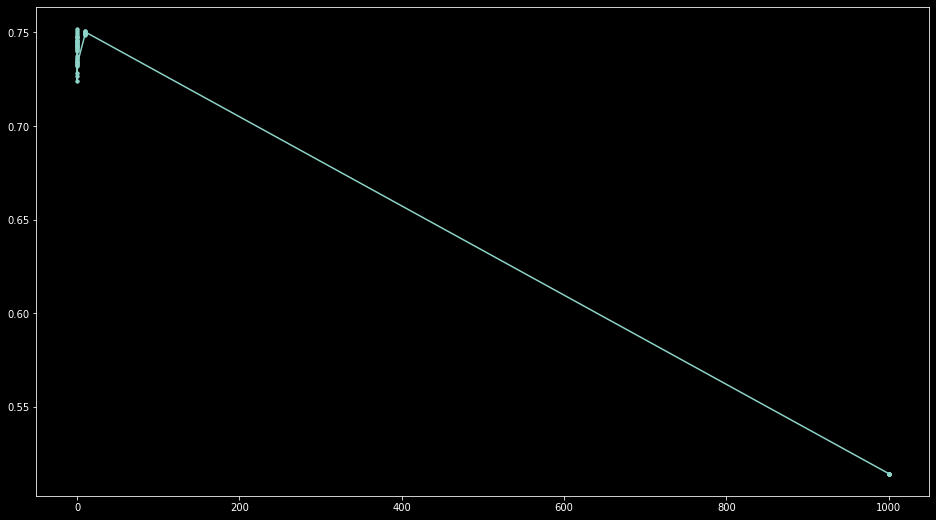

In [ ]:
plt.plot(df['alpha'], df['accuracy'], marker='.', ls = '-')
pass

In [ ]:
best_value = max(clf.cv_results_['mean_test_score'])

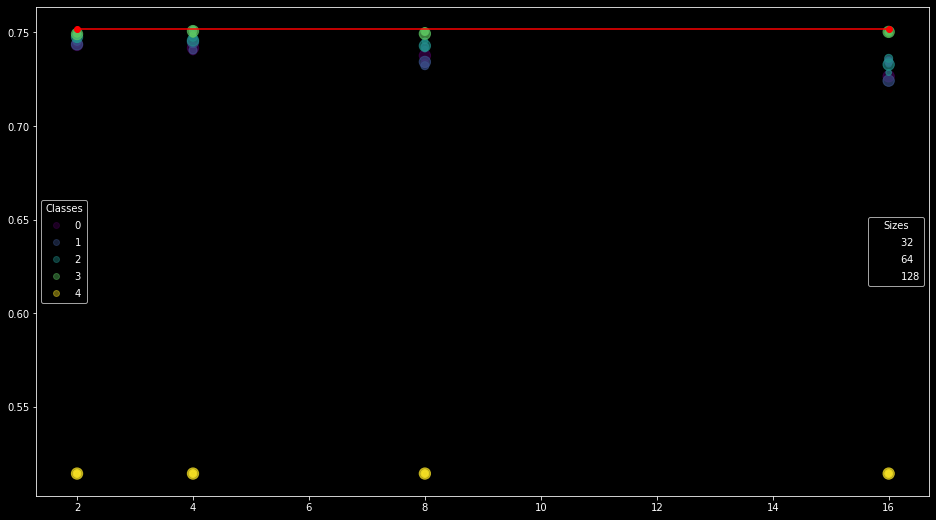

In [ ]:
fig, ax = plt.subplots()

scatter = ax.scatter(df['first_layer_size'], df['accuracy'], s=df['second_layer_size'], c = df['alpha_index'], alpha=0.4)
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="center left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=1)
legend2 = ax.legend(handles, labels, loc="center right", title="Sizes")

plt.plot((2, 16), (best_value, best_value), 'ro-')

ax.add_artist(legend1)

In [21]:
%%time
mlp_model = MLPClassifier(alpha = 0.1, hidden_layer_sizes = (4, 32), max_iter = 2048, random_state = 42)
mlp_model.fit(X_train, y_train)
print("Train: {:.5f}, Test: {:.5f}".format(
    mlp_model.score(X_train, y_train),
    mlp_model.score(X_test, y_test))
)

Train: 0.75736, Test: 0.75506
CPU times: user 16.9 s, sys: 75.7 ms, total: 17 s
Wall time: 17 s


#### Bigger sizes CV

In [25]:
input_size = data.shape[1]
print(input_size)
layers_sizes = []
for l1 in [64, 128, 192, 256]:
    for l2 in [256, 512, 768, 1024, 1280]:
        if l1 <= l2:
            layers_sizes.append((l1, l2))
print(len(layers_sizes))
print(layers_sizes)
alphas = alphas = np.logspace(-4, 2, 3)
alphas.sort()
alphas

56
20
[(64, 256), (64, 512), (64, 768), (64, 1024), (64, 1280), (128, 256), (128, 512), (128, 768), (128, 1024), (128, 1280), (192, 256), (192, 512), (192, 768), (192, 1024), (192, 1280), (256, 256), (256, 512), (256, 768), (256, 1024), (256, 1280)]


array([1.e-04, 1.e-01, 1.e+02])

In [27]:
parameter_space = {
    'hidden_layer_sizes': layers_sizes,
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': alphas,
    'learning_rate': ['constant','adaptive'],
}
parameter_space

{'activation': ['relu'],
 'alpha': array([1.e-04, 1.e-01, 1.e+02]),
 'hidden_layer_sizes': [(64, 256),
  (64, 512),
  (64, 768),
  (64, 1024),
  (64, 1280),
  (128, 256),
  (128, 512),
  (128, 768),
  (128, 1024),
  (128, 1280),
  (192, 256),
  (192, 512),
  (192, 768),
  (192, 1024),
  (192, 1280),
  (256, 256),
  (256, 512),
  (256, 768),
  (256, 1024),
  (256, 1280)],
 'learning_rate': ['constant', 'adaptive'],
 'solver': ['adam']}

In [ ]:
from sklearn.model_selection import GridSearchCV

mlp = MLPClassifier(max_iter=256, random_state = 42)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
df_array = []
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    row = {}
    row['accuracy'] = mean
    row['learning_rate'] = params['learning_rate']
    row['alpha'] = params['alpha']
    row['first_layer_size'] = params['hidden_layer_sizes'][0]
    row['second_layer_size'] = params['hidden_layer_sizes'][1]
    row['total_sum'] = params['hidden_layer_sizes'][1] + params['hidden_layer_sizes'][0]
    row['total_prod'] = params['hidden_layer_sizes'][1] * params['hidden_layer_sizes'][0]
    df_array.append(row)
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [ ]:
y_true, y_pred = y_test , clf.predict(X_test)

from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred))

In [ ]:
df_array

###More hidden layers

In [ ]:
%%time
mlp_model = MLPClassifier(alpha = 0.0001, hidden_layer_sizes = (128, 256, 512, 128), max_iter = 2048, random_state = 42)
mlp_model.fit(X_train, y_train)
print("Train: {:.5f}, Test: {:.5f}".format(
    mlp_model.score(X_train, y_train),
    mlp_model.score(X_test, y_test))
)

Train: 0.98889, Test: 0.88108
CPU times: user 33min 16s, sys: 12min 6s, total: 45min 22s
Wall time: 23min 11s
